In [1]:
import src
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
%matplotlib inline

### Choice of data and goal
- Data frames come from the same website so I can join on the column tconst with no lost observation other than
    differences dataframe length
- I want to create a dataframe that tags each observation with the genre that is in it's genre list
- Once I have merged, cleaned and added the genre boolean columns I will do rating by genre of recent years and 
    sufficently high vote count to convince me the findings are valid
- Once I have a dataframe with individual genres, I want to merge that with a dataframe containing the budgets for each movie. 


In [2]:
df_title = pd.read_csv('../zippedData/imdb.title.basics.csv.gz')
df_ratings = pd.read_csv('../zippedData/imdb.title.ratings.csv.gz')
df_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
print(f'df_title has a shape of {df_title.shape} and df_ratings has a shape of {df_ratings.shape}')

df_title has a shape of (146144, 6) and df_ratings has a shape of (73856, 3)


In [3]:
# merge the two data sets on tconst:
df_merge = df_title.merge(df_ratings, on='tconst', how='inner')
print(f'df_merge has a shape of {df_merge.shape}')

# remove all null values from the genres column
df = src.remove_null_genre(df_merge, 'genres')

#coerce the genres to a list:
df.genres = src.coerce_to_list(df, 'genres')

# Create a data frame containing only data released since the year 2000 and before 2020
df_scaffold = df[(df.start_year<2020)]
# choice of column for the data frames
df_scaffold = df_scaffold[['tconst',
                           'primary_title', 
                           'genres', 
                           'numvotes', 
                           'averagerating',
                           'start_year', 
                           'runtime_minutes']]

# Create boolean sereis for each genre in list and append it to a scaffold df documentation in src
df_genres = src.generate_genre_dataframe(df_scaffold)
print(f'df_genres has a shape of {df_genres.shape}')

df_merge has a shape of (73856, 8)
df_genres has a shape of (73052, 33)


In [4]:
df_genres.head()

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Action,News,Family,...,Music,Game-Show,Sci-Fi,Fantasy,Adventure,War,Musical,Comedy,Adult,History
0,tt0063540,Sunghursh,"[Action, Crime, Drama]",77,7.0,2013,175.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0066787,One Day Before the Rainy Season,"[Biography, Drama]",43,7.2,2019,114.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0069049,The Other Side of the Wind,[Drama],4517,6.9,2018,122.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tt0069204,Sabse Bada Sukh,"[Comedy, Drama]",13,6.1,2018,NaN,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,tt0100275,The Wandering Soap Opera,"[Comedy, Drama, Fantasy]",119,6.5,2017,80.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False


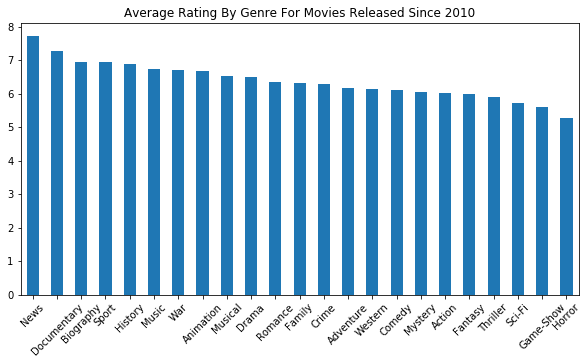

In [5]:
# Generate a plot of the data and visualise the ratings per genre. check documentation in src
df_genres_highvotes = df_genres[df_genres.numvotes >1000]
df_ratings = src.genre_pandas_mean(df_genres_highvotes, 'averagerating')

df_ratings.plot(kind='bar', figsize=(10,5), title='Average Rating By Genre For Movies Released Since 2010', legend=False)
plt.xticks(rotation=45);

In [6]:
# Change the genres back to a string before we save for ease of further analysis
df_genres.genres = src.list_to_string(df_genres, 'genres')

# Save the data frame as a csv and continue on to budget by genre
df_genres.to_csv('basics-ratings-genre.csv', index=False)


# change the genres back to a list as my graphing functions require it to be in that format
df_genres.genres = src.coerce_to_list_by_space(df_genres, 'genres')

In [7]:
df_genres.genres

0          [Action, Crime, Drama]
1              [Biography, Drama]
2                         [Drama]
3                 [Comedy, Drama]
4        [Comedy, Drama, Fantasy]
                   ...           
73850               [Documentary]
73851               [Documentary]
73852             [Drama, Family]
73853               [Documentary]
73855               [Documentary]
Name: genres, Length: 73052, dtype: object

In [8]:
# Before a merge, let's clean up the data frames with a string cleaning function. lower allthe titles and remove whitespace
df_budgets.movie=src.string_cleaner(df_budgets.movie)
df_genres.primary_title=src.string_cleaner(df_genres.primary_title)

In [9]:
# perform a merge on genres left on primary_title right on movie
df =df_genres.merge(df_budgets, how='inner', left_on='primary_title', right_on='movie')

In [10]:
df.shape

(2927, 39)

In [11]:
# Now that we have our dataframe, albeit heavily reduced in size, we should cleanup the columns and save it
df.head(3)

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Action,News,Family,...,Musical,Comedy,Adult,History,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,foodfight!,"[Action, Animation, Comedy]",8248,1.9,2012,91.0,True,False,False,...,False,True,False,False,26,"Dec 31, 2012",foodfight!,"$45,000,000",$0,"$73,706"
1,tt0337692,on the road,"[Adventure, Drama, Romance]",37886,6.1,2012,124.0,False,False,False,...,False,False,False,False,17,"Mar 22, 2013",on the road,"$25,000,000","$720,828","$9,313,302"
2,tt4339118,on the road,[Drama],6,6.0,2014,89.0,False,False,False,...,False,False,False,False,17,"Mar 22, 2013",on the road,"$25,000,000","$720,828","$9,313,302"


In [12]:
# Use the string to float function we built to fix these columns
df.production_budget = src.string_to_float(df.production_budget)
df.domestic_budget = src.string_to_float(df.domestic_gross)
df.worldwide_gross = src.string_to_float(df.worldwide_gross)

In [13]:
# Create a release year column
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df.release_date.dt.strftime('%Y').astype(int)
# Filter movie by start date being after 2010
df = df[df.year > 2009]
len(df)

2261

In [14]:

# Create a return on investment column
df['roi'] = (df.worldwide_gross-df.production_budget)/df.production_budget*100

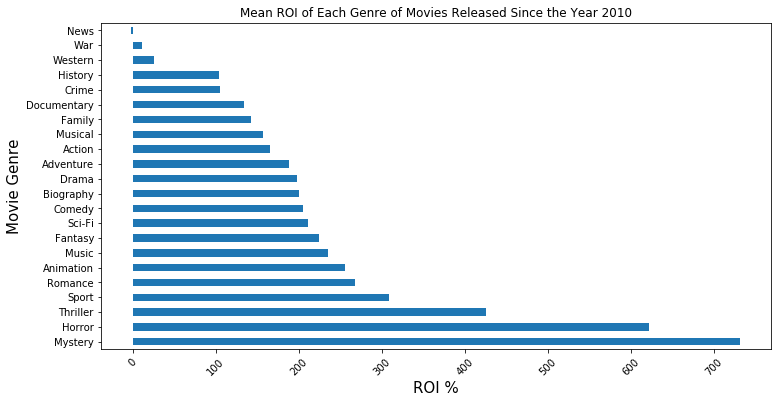

In [15]:
df_to_plot = src.genre_pandas_mean(df, 'roi')
df_to_plot.plot(kind='barh', legend=False,figsize=(12,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Since the Year 2010')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

In [16]:
# drop extra columns that we didn't use.
df.head()
df.drop(columns= ["primary_title",
                 'id'],
        inplace = True
       )

# Save as a new csv!
df.to_csv('genres-budget.csv', index=False)

In [17]:
df.head()

,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Action,News,Family,Sport,...,Comedy,Adult,History,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,roi
0,tt0249516,"[Action, Animation, Comedy]",8248,1.9,2012,91.0,True,False,False,False,...,True,False,False,2012-12-31,foodfight!,45000000.0,$0,73706.0,2012,-99.836209
1,tt0337692,"[Adventure, Drama, Romance]",37886,6.1,2012,124.0,False,False,False,False,...,False,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,-62.746792
2,tt4339118,[Drama],6,6.0,2014,89.0,False,False,False,False,...,False,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,-62.746792
3,tt5647250,[Drama],127,5.7,2016,121.0,False,False,False,False,...,False,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,-62.746792
4,tt0359950,"[Adventure, Comedy, Drama]",275300,7.3,2013,114.0,False,False,False,False,...,True,False,False,2013-12-25,the secret life of walter mitty,91000000.0,"$58,236,838",187861183.0,2013,106.440860


In [18]:
df_combo_genre = pd.read_csv('genres-budget.csv')
# # Next question is what combination of genres is best?

# # reloud the dataframe with string values for genres
# df_combo_genre = pd.read_csv('genres-budget.csv')
# df.sort_values('roi', ascending=False)[:26].groupby(['genres']).tconst.count().sort_values(ascending=False)

In [19]:
df_combo_genre.genres = src.string_from_list(df_combo_genre, 'genres')

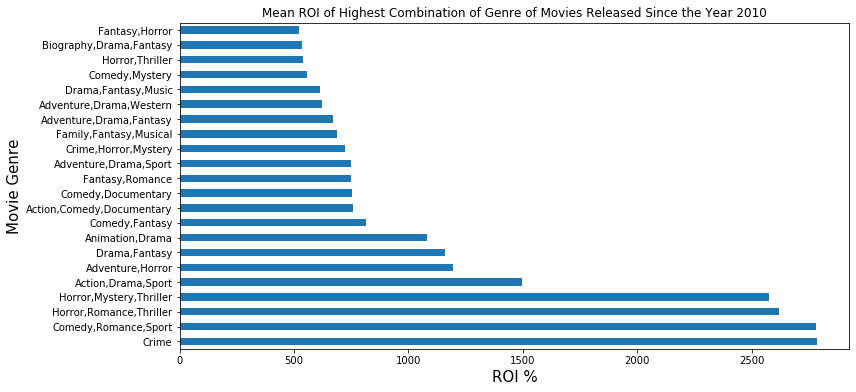

In [20]:
grouped_top_22_genres = df_combo_genre.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

grouped_top_22_genres.plot(kind='barh', legend=False,figsize=(12,6))
plt.title('Mean ROI of Highest Combination of Genre of Movies Released Since the Year 2010')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre_combo.png')

In [21]:
df_combo_genre.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

genres
Crime                        2787.319504
Comedy,Romance,Sport         2780.763331
Horror,Romance,Thriller      2617.924114
Horror,Mystery,Thriller      2576.754351
Action,Drama,Sport           1495.049681
Adventure,Horror             1193.142000
Drama,Fantasy                1159.879340
Animation,Drama              1079.569540
Comedy,Fantasy                816.138009
Action,Comedy,Documentary     758.428965
Comedy,Documentary            752.441810
Fantasy,Romance               748.313273
Adventure,Drama,Sport         748.313273
Crime,Horror,Mystery          723.461162
Family,Fantasy,Musical        686.999816
Adventure,Drama,Fantasy       670.475174
Adventure,Drama,Western       620.791223
Drama,Fantasy,Music           612.328818
Comedy,Mystery                558.039191
Horror,Thriller               538.977586
Biography,Drama,Fantasy       533.972000
Fantasy,Horror                521.953522
Name: roi, dtype: float64

,Unnamed: 0,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Family,Comedy,Biography,...,Documentary,Mystery,Drama,Game-Show,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi
295,295,tt4360484,"Biography,Documentary",15,5.9,2016,80.0,False,False,True,...,True,False,False,False,"Apr 16, 2010",the joneses,10000000.0,"$1,475,746",3541565.0,-64.584350
353,353,tt4597838,"Biography,Documentary",10,6.7,2015,3.0,False,False,True,...,True,False,False,False,"Mar 18, 2011",limitless,27000000.0,"$79,249,455",155564919.0,476.166367
1365,1365,tt1822382,"Biography,Documentary",732,7.4,2011,105.0,False,False,True,...,True,False,False,False,"Dec 31, 2019",reagan,25000000.0,$0,0.0,-100.000000
1920,1920,tt2294916,"Biography,Documentary",156,7.2,2014,81.0,False,False,True,...,True,False,False,False,"Dec 31, 2014",the image revolution,50000.0,$0,0.0,-100.000000
2124,2124,tt2560702,"Biography,Documentary",13,7.5,2012,50.0,False,False,True,...,True,False,False,False,"Aug 25, 2017",ballerina,30000000.0,"$21,858,070",96892829.0,222.976097
2165,2165,tt2668120,"Biography,Documentary",101,7.0,2013,58.0,False,False,True,...,True,False,False,False,"Aug 13, 1942",bambi,858000.0,"$102,797,000",268000000.0,31135.431235
